In [42]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/cleaned_heart.csv')

In [3]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140.0,289.0,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160.0,180.0,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130.0,283.0,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138.0,214.0,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150.0,195.0,0,Normal,122,N,0.0,Up,0


### Aiming for high recall remember!!

In [123]:
from sklearn.model_selection import train_test_split
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [88]:
categorical_preprocessing = Pipeline([('ohe', OneHotEncoder())])
numerical_preprocessing = Pipeline([('imputer', KNNImputer(n_neighbors=5))])
preprocess = ColumnTransformer([
    ('categorical_preprocessing', categorical_preprocessing, ['ChestPainType','RestingECG','ST_Slope','Sex','FastingBS','ExerciseAngina']),
    ('numerical_preprocessing', numerical_preprocessing, ['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']),
    ('scaler', StandardScaler(), ['Age','RestingBP','Cholesterol','MaxHR','Oldpeak'])
])

In [106]:
pipeline_baseline = Pipeline([
    ('preprocess', preprocess),
    ('lr', LogisticRegression(max_iter=500))
])

In [40]:
pipeline_baseline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('categorical_preprocessing',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder())]),
                                                  ['ChestPainType',
                                                   'RestingECG', 'ST_Slope',
                                                   'Sex', 'FastingBS',
                                                   'ExerciseAngina']),
                                                 ('numerical_preprocessing',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer())]),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'MaxHR',
                                                   'Oldpeak']),
                                                 ('scaler', StandardScaler(),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'MaxHR',
                                                   'Oldpeak'])])),
                ('lr', LogisticRegression(max_iter=500))])

In [107]:
pipeline_baseline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('categorical_preprocessing',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder())]),
                                                  ['ChestPainType',
                                                   'RestingECG', 'ST_Slope',
                                                   'Sex', 'FastingBS',
                                                   'ExerciseAngina']),
                                                 ('numerical_preprocessing',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer())]),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'MaxHR',
                                                   'Oldpeak']),
                                                 ('scaler', StandardScaler(),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'MaxHR',
                                                   'Oldpeak'])])),
                ('lr', LogisticRegression(max_iter=500))])

In [129]:
pipeline_baseline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('categorical_preprocessing',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder())]),
                                                  ['ChestPainType',
                                                   'RestingECG', 'ST_Slope',
                                                   'Sex', 'FastingBS',
                                                   'ExerciseAngina']),
                                                 ('numerical_preprocessing',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer())]),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'MaxHR',
                                                   'Oldpeak']),
                                                 ('scaler', StandardScaler(),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'MaxHR',
                                                   'Oldpeak'])])),
                ('lr', LogisticRegression(max_iter=500))])

In [130]:
y_predicted = pipeline_baseline.predict(X_test)
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
r2 = r2_score(y_test, y_predicted)
acc = accuracy_score(y_test, y_predicted)
recal = recall_score(y_test, y_predicted)
precision = precision_score(y_test, y_predicted)
print('r2 score:', r2)
print('accuracy score:', acc)
print('recall score:', recal)
print('precision score:', precision)

r2 score: 0.321277239709443
accuracy score: 0.8304347826086956
recall score: 0.875
precision score: 0.7967479674796748


In [47]:
import pickle
pickle.dump(pipeline_baseline, open( "../models/baseline_pipeline", "wb" ) )

In [3]:
#baseline is done

In [89]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [90]:
pipeline_rfc = Pipeline([
    ('preprocess', preprocess),
    ('rfc', RandomForestClassifier())
])

In [91]:
params_rfc = {"rfc__n_estimators": [50, 100, 200],
                  "rfc__max_depth": [5, 10, 20]
                 }

In [92]:
gs_rfc = GridSearchCV(pipeline_rfc, params_rfc, cv=5)

In [124]:
gs_rfc.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('categorical_preprocessing',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder())]),
                                                                         ['ChestPainType',
                                                                          'RestingECG',
                                                                          'ST_Slope',
                                                                          'Sex',
                                                                          'FastingBS',
                                                                          'ExerciseAngina']),
                                                                        ('numerical_preprocessing',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer())]),
                                                                         ['Age',
                                                                          'RestingBP',
                                                                          'Cholesterol',
                                                                          'MaxHR',
                                                                          'Oldpeak']),
                                                                        ('scaler',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'RestingBP',
                                                                          'Cholesterol',
                                                                          'MaxHR',
                                                                          'Oldpeak'])])),
                                       ('rfc', RandomForestClassifier())]),
             param_grid={'rfc__max_depth': [5, 10, 20],
                         'rfc__n_estimators': [50, 100, 200]})

In [125]:
gs_rfc.best_params_

{'rfc__max_depth': 10, 'rfc__n_estimators': 50}

In [126]:
rfc_best = gs_rfc.best_estimator_

In [127]:
y_predicted = rfc_best.predict(X_test)

In [128]:
r2 = r2_score(y_test, y_predicted)
acc = accuracy_score(y_test, y_predicted)
recal = recall_score(y_test, y_predicted)
precision = precision_score(y_test, y_predicted)
print('r2 score:', r2)
print('accuracy score:', acc)
print('recall score:', recal)
print('precision score:', precision)

r2 score: 0.37348668280871655
accuracy score: 0.8434782608695652
recall score: 0.9107142857142857
precision score: 0.796875


In [165]:
#save this model to compare to one created after
import pickle
pickle.dump(rfc_best, open( "../models/initial_rfc_pipeline", "wb" ) )

In [23]:
#This RFC model has a better recall than the baseline
#find out best features from it and reduce (background stuff can just be noise)

In [131]:
pipeline_svc = Pipeline([
    ('preprocess', preprocess),
    ('svc', SVC())
])

In [132]:
params_svc = {"svc__C": [0.1, 1.0, 10],
                "svc__kernel": ['linear'],
              'svc__gamma': [1, 0.1, 0.01, 0.001]
                 }

In [133]:
gs_svc = GridSearchCV(pipeline_svc, params_svc, cv=5)

In [134]:
gs_svc.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('categorical_preprocessing',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder())]),
                                                                         ['ChestPainType',
                                                                          'RestingECG',
                                                                          'ST_Slope',
                                                                          'Sex',
                                                                          'FastingBS',
                                                                          'ExerciseAngina']),
                                                                        ('numerical_preprocessing',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer())]),
                                                                         ['Age',
                                                                          'RestingBP',
                                                                          'Cholesterol',
                                                                          'MaxHR',
                                                                          'Oldpeak']),
                                                                        ('scaler',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'RestingBP',
                                                                          'Cholesterol',
                                                                          'MaxHR',
                                                                          'Oldpeak'])])),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [0.1, 1.0, 10],
                         'svc__gamma': [1, 0.1, 0.01, 0.001],
                         'svc__kernel': ['linear']})

In [135]:
svc_best = gs_svc.best_estimator_

In [136]:
y_predicted = svc_best.predict(X_test)

In [137]:
r2 = r2_score(y_test, y_predicted)
acc = accuracy_score(y_test, y_predicted)
recal = recall_score(y_test, y_predicted)
precision = precision_score(y_test, y_predicted)
print('r2 score:', r2)
print('accuracy score:', acc)
print('recall score:', recal)
print('precision score:', precision)

r2 score: 0.26906779661016933
accuracy score: 0.8173913043478261
recall score: 0.8571428571428571
precision score: 0.7868852459016393


In [138]:
#svc linear kernal performed worse than rfc

In [75]:
#low chance this will even be good
from sklearn.naive_bayes import GaussianNB
pipeline_nb = Pipeline([
    ('preprocess', preprocess),
    ('nb', GaussianNB())
])

In [78]:
pipeline_nb.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('categorical_preprocessing',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder())]),
                                                  ['ChestPainType',
                                                   'RestingECG', 'ST_Slope',
                                                   'Sex', 'FastingBS',
                                                   'ExerciseAngina']),
                                                 ('numerical_preprocessing',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer())]),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'MaxHR',
                                                   'Oldpeak']),
                                                 ('scaler', StandardScaler(),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'MaxHR',
                                                   'Oldpeak'])])),
                ('nb', GaussianNB())])

In [79]:
y_predicted = pipeline_nb.predict(X_test)

In [80]:
r2 = r2_score(y_test, y_predicted)
acc = accuracy_score(y_test, y_predicted)
recal = recall_score(y_test, y_predicted)
precision = precision_score(y_test, y_predicted)
print('r2 score:', r2)
print('accuracy score:', acc)
print('recall score:', recal)
print('precision score:', precision)

r2 score: 0.2884159555736149
accuracy score: 0.8229317851959361
recall score: 0.8288043478260869
precision score: 0.8379120879120879


In [81]:
#worst model so far

In [37]:
#getting feature importances from random forest

In [69]:
ohe = OneHotEncoder(sparse=False)
ohe_df = ohe.fit_transform(df[['ChestPainType','RestingECG','ST_Slope','Sex','FastingBS','ExerciseAngina']])

In [70]:
col_names = ohe.get_feature_names_out()

In [71]:
ohe_df = pd.DataFrame(ohe_df, columns = col_names)

In [76]:
ss = StandardScaler()
scaled = ss.fit_transform(df[['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']])
names = ['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']

In [78]:
scaled = pd.DataFrame(scaled, columns = names)

In [80]:
combined = pd.concat([scaled, ohe_df], axis=1, join='inner')

In [152]:
column_names = combined.columns

In [144]:
from sklearn.model_selection import train_test_split
X = combined.iloc[:,:-1]
y = df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [145]:
clf = RandomForestClassifier(max_depth=10, n_estimators=50)

In [147]:
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=50)

In [149]:
y_predicted = clf.predict(X_test)

In [150]:
r2 = r2_score(y_test, y_predicted)
acc = accuracy_score(y_test, y_predicted)
recal = recall_score(y_test, y_predicted)
precision = precision_score(y_test, y_predicted)
print('r2 score:', r2)
print('accuracy score:', acc)
print('recall score:', recal)
print('precision score:', precision)

r2 score: 0.4608695652173913
accuracy score: 0.8652173913043478
recall score: 0.9217391304347826
precision score: 0.828125


In [ ]:
#similar to created model from pipeline, can now extract feature importances easier as well

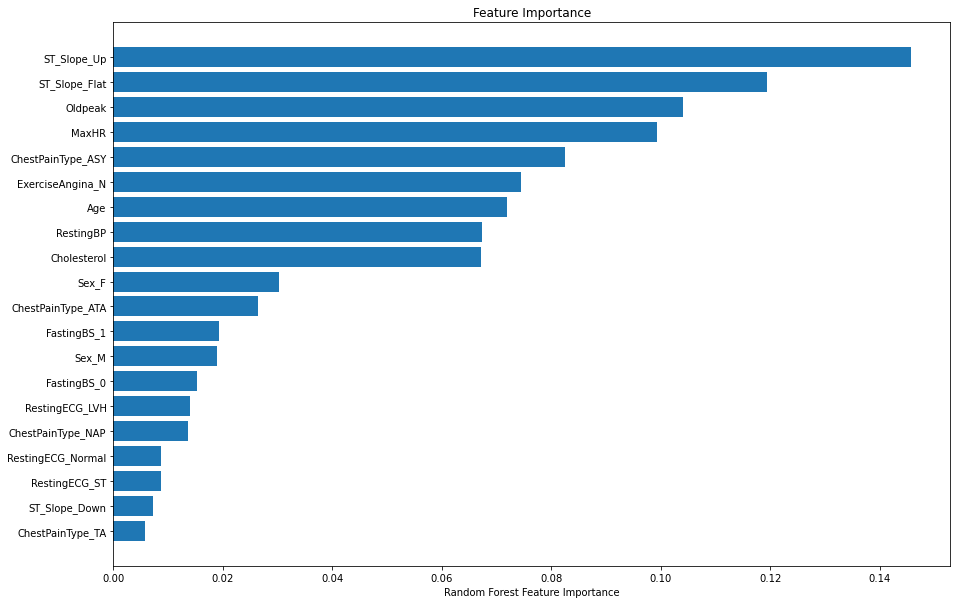

In [158]:
plt.figure(figsize=(15,10))
feature_imp = clf.feature_importances_
indexs = np.argsort(feature_imp)
plt.title("Feature Importance")
plt.barh(range(len(indexs)),feature_imp[indexs],align="center")
plt.yticks(range(len(indexs)),[column_names[i] for i in indexs])
plt.xlabel("Random Forest Feature Importance")
#plt.tight_layout()
plt.show()

In [163]:
plt.savefig('../figures/feature_importance.png')

<Figure size 432x288 with 0 Axes>

In [159]:
#Based on what is seen from this graph, ST slope, old peak, max heart rate, chest pain type (but only asy or not symp), age, max hr, resting bp and cholesterol make up most of 
#the importance, can cut down features such as resting ECG, fasting BS, even sex doesnt seem to be too important, and retrain a new model